![Baseball Flights](baseball_flights.png)


To the Office of Transportation at The 22nd Century Sporting League,

After our inaugural 2101 season, The League is looking for ways to optimize our game scheduling process and costs.  We know that transportation logistics are a major variable to consider during scheduling. 

Our primary areas of focus are surrounding the number of jets that The League needs to own, and the cost of fuel for those flights. If we want The League to enjoy continued success, we'll need to make sure we manage transportation costs.

We’re sharing schedule data for the upcoming 2102 season.  On each row it shows the information about which teams are needing to travel to their next set of games, the time the flight will likely depart (based on our estimations of gameplay durations) and the time the flight will likely land. 

Additionally, we're also providing the fuel price that was paid each day during this past 2101 season. The fuel price fluctuates over time, but hope to project it to the future to help with the analysis.

## The Data

### team_flights.csv

| Column     | Description              |
|------------|--------------------------|
| `team_name` | Official team name |
| `departure_datetime` | Date and Time (in UTC) when the flight will depart |
| `landing_datetime` | Date and Time (in UTC) when the flight will land |


### fuel_price.csv

| Column     | Description              |
|------------|--------------------------|
| `date` | Date when the fuel price was recorded |
| `fuel_price` | Corresponding fuel price (in $ per gallon) |


### Important Things to Know
- You can assume that the flight's average speed is 500 MPH. (So, as an example, a 2-hour flight would travel 1000 miles)
- You can assume that each team’s jet fills up with fuel equivalent to 1 gallon per mile-of-travel 
- You can assume that the jet is fueled on the day the travel departs (and thus can use the fuel price corresponding to the departure date)

In [1]:
# Import required modules
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


# Explore the data
team_flights = pd.read_csv('./team_flights.csv', parse_dates=['departure_datetime', 'landing_datetime'])
fuel_prices = pd.read_csv('./fuel_prices_2101.csv',
                         index_col='date')

team_flights.head()

,team_name,departure_datetime,landing_datetime,travel_distance_miles
0,Agile Antelopes,2102-04-06 21:37:00,2102-04-07 00:35:57,1491.250000
1,Agile Antelopes,2102-04-10 23:57:00,2102-04-11 01:35:40,822.222222
2,Agile Antelopes,2102-04-14 00:29:00,2102-04-14 05:02:55,2282.638889
3,Agile Antelopes,2102-04-21 03:31:00,2102-04-21 05:23:09,934.583333
4,Agile Antelopes,2102-04-24 22:23:00,2102-04-25 00:25:50,1023.611111


In [2]:
team_flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1145 entries, 0 to 1144
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   team_name              1145 non-null   object        
 1   departure_datetime     1145 non-null   datetime64[ns]
 2   landing_datetime       1145 non-null   datetime64[ns]
 3   travel_distance_miles  1145 non-null   float64       
dtypes: datetime64[ns](2), float64(1), object(1)
memory usage: 35.9+ KB


In [3]:
team_flights.describe()

,travel_distance_miles
count,1145.000000
mean,1054.579937
std,771.374491
min,6.527778
25%,407.777778
50%,917.083333
75%,1520.555556
max,4203.611111


In [4]:
team_flights.isna().sum()

team_name                0
departure_datetime       0
landing_datetime         0
travel_distance_miles    0
dtype: int64

In [5]:
team_flights.duplicated().sum()

0

In [6]:
team_flights.tail()

,team_name,departure_datetime,landing_datetime,travel_distance_miles
1140,Diligent Data Scientists,2102-09-05 01:22:00,2102-09-05 03:14:19,935.972222
1141,Diligent Data Scientists,2102-09-07 23:56:00,2102-09-08 04:26:26,2253.611111
1142,Diligent Data Scientists,2102-09-18 22:20:00,2102-09-18 23:00:50,340.277778
1143,Diligent Data Scientists,2102-09-23 03:37:00,2102-09-23 05:40:32,1029.444444
1144,Diligent Data Scientists,2102-09-25 22:04:00,2102-09-26 00:17:24,1111.666667


In [7]:
# Some basic data cleaning and pre-processing
fuel_prices.index = pd.DatetimeIndex(fuel_prices.index).to_period('D')

In [8]:
# Combine all the time moments including departure & landing
comb = pd.concat([team_flights['departure_datetime'], 
                  team_flights['landing_datetime']]).sort_values().reset_index(drop=True)


In [9]:
# combd = pd.DataFrame(comb.unique())
combd_date = list(comb.unique())
combd_num = [0 for i in combd_date]

for i in range(len(combd_date)):
    combd_num[i] = ((team_flights['departure_datetime']<= combd_date[i]) 
                    & (team_flights['landing_datetime']>=combd_date[i])).sum()


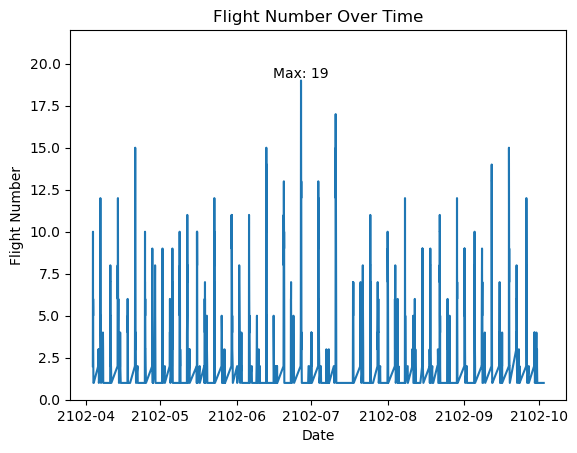

In [10]:
# plot the number of flights on each datetime
plt.plot(combd_date, combd_num)
max_num = max(combd_num)

x = combd_date[combd_num.index(max_num)]
y = combd_num[combd_num.index(max_num)]

plt.text(x, y, f'Max: {max_num}',ha='center', va='bottom');

plt.ylim(0, max_num + 3)
plt.xlabel('Date') 
plt.ylabel('Flight Number') 
plt.title('Flight Number Over Time')
plt.show()

In [11]:
fuel_prices.head()

,price
date,
2101-01-01,0.97
2101-01-02,0.87
2101-01-03,0.87
2101-01-04,0.97
2101-01-05,1.10


In [12]:
fuel_prices.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 365 entries, 2101-01-01 to 2101-12-31
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   365 non-null    float64
dtypes: float64(1)
memory usage: 5.7 KB


In [13]:
fuel_prices.describe()

,price
count,365.000000
mean,1.183863
std,0.150762
min,0.870000
25%,1.080000
50%,1.180000
75%,1.290000
max,1.510000


In [14]:
fuel_prices.isna().sum()

price    0
dtype: int64

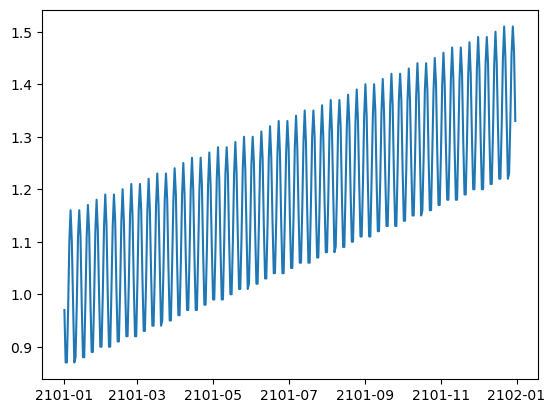

In [15]:
# Convert the PeriodIndex to a datetime index
fuel_prices.index = fuel_prices.index.to_timestamp()

# Now plot the data
plt.plot(fuel_prices);
plt.show()

In [16]:
# check for stationarity
from statsmodels.tsa.stattools import adfuller

res = adfuller(fuel_prices['price'])

print('ADF Statistic', res[0])
print('p value', res[1])

ADF Statistic 0.10529145706821667
p value 0.9664205149823061


[]

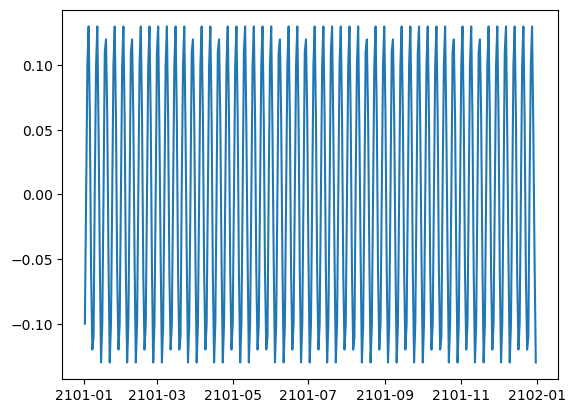

In [17]:
#difference to make data stationary

fuel_prices['price_diff'] = fuel_prices['price'].diff().dropna()
plt.plot(fuel_prices['price_diff'])
plt.plot()

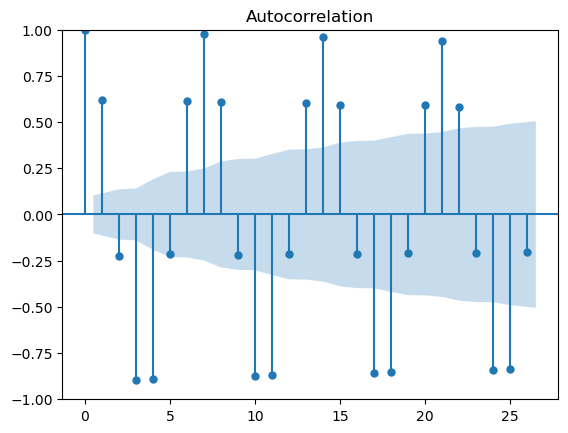

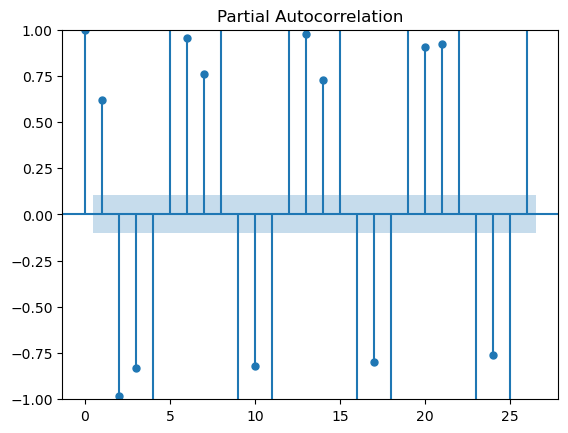

In [18]:
#determin order of the model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(fuel_prices['price_diff'].dropna())
plot_pacf(fuel_prices['price_diff'].dropna())
plt.show()


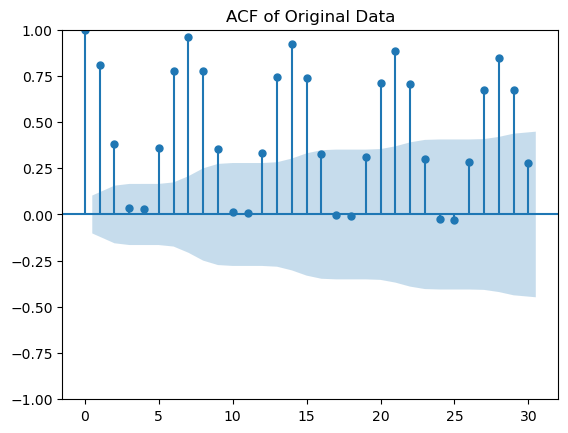

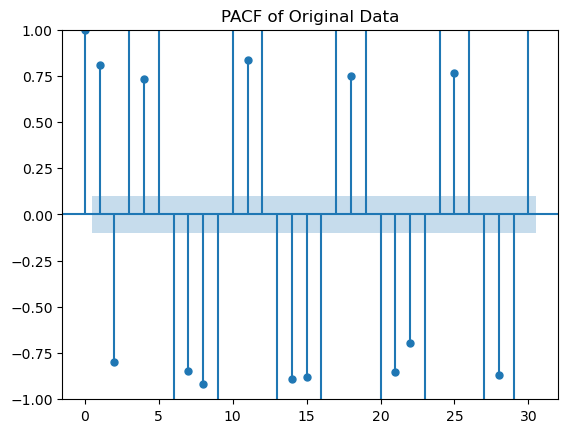

In [19]:
# To find seasonal components, you can look at ACF/PACF again focusing on seasonal lags
plot_acf(fuel_prices['price'], lags=30)  # or just seasonal lags like [7, 14, 21, ...]
plt.title('ACF of Original Data')
plt.show()

plot_pacf(fuel_prices['price'], lags=30)
plt.title('PACF of Original Data')
plt.show()

In [20]:
#fit the model with orders
model = SARIMAX(fuel_prices['price'], order=(1, 1, 1), seasonal_order=(1, 0, 1, 7))
results = model.fit()
print(results.summary())


                                     SARIMAX Results                                     
Dep. Variable:                             price   No. Observations:                  365
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 7)   Log Likelihood                1467.182
Date:                           Wed, 22 Jan 2025   AIC                          -2924.364
Time:                                   19:03:55   BIC                          -2904.878
Sample:                               01-01-2101   HQIC                         -2916.619
                                    - 12-31-2101                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0069      0.058     -0.120      0.905      -0.120       0.106
ma.L1         -0.8556      0.032    -26.501

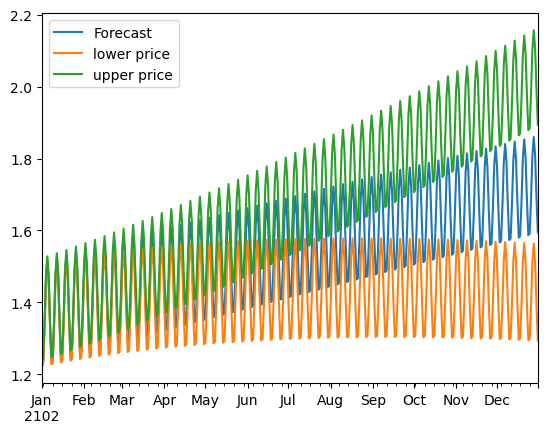

In [21]:
# Forecast future gas prices 

forecast = results.get_forecast(steps=365) 
forecast_df = forecast.conf_int() 
forecast_df['Forecast'] = results.predict(start=forecast_df.index[0], end=forecast_df.index[-1])
forecast_df[['Forecast','lower price', 'upper price']].plot() 
plt.show()

In [22]:
forecast_df.head(3)

,lower price,upper price,Forecast
2102-01-01,1.222504,1.238555,1.230529
2102-01-02,1.226690,1.242892,1.234791
2102-01-03,1.327320,1.343685,1.335503


In [23]:
forecast_df.shape

(365, 3)

In [24]:
# bring the forecast price to team_flights df
team_flights['departure_date'] = pd.to_datetime(team_flights['departure_datetime'].dt.date)


team_flights_ny = team_flights.merge(forecast_df[['Forecast']], how = 'left', left_on = 'departure_date', right_index = True)
team_flights_ny.head(10)

,team_name,departure_datetime,landing_datetime,travel_distance_miles,departure_date,Forecast
0,Agile Antelopes,2102-04-06 21:37:00,2102-04-07 00:35:57,1491.250000,2102-04-06,1.608351
1,Agile Antelopes,2102-04-10 23:57:00,2102-04-11 01:35:40,822.222222,2102-04-10,1.334679
2,Agile Antelopes,2102-04-14 00:29:00,2102-04-14 05:02:55,2282.638889,2102-04-14,1.561405
3,Agile Antelopes,2102-04-21 03:31:00,2102-04-21 05:23:09,934.583333,2102-04-21,1.568222
4,Agile Antelopes,2102-04-24 22:23:00,2102-04-25 00:25:50,1023.611111,2102-04-24,1.348820
5,Agile Antelopes,2102-04-29 03:57:00,2102-04-29 04:22:29,212.361111,2102-04-29,1.451801
6,Agile Antelopes,2102-05-05 21:00:00,2102-05-06 00:57:28,1978.888889,2102-05-05,1.581831
7,Agile Antelopes,2102-05-09 01:28:00,2102-05-09 02:46:14,651.944444,2102-05-09,1.461598
8,Agile Antelopes,2102-05-12 00:14:00,2102-05-12 05:06:14,2435.277778,2102-05-12,1.588624
9,Agile Antelopes,2102-05-17 00:39:00,2102-05-17 02:29:51,923.750000,2102-05-17,1.595237


In [25]:
# total cost for fuel
total_fuel_spend_2102_dollars = (team_flights_ny['travel_distance_miles']*team_flights_ny['Forecast']).sum()
total_fuel_spend_2102_dollars

1866431.5536065737